In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from scipy import stats
import scipy
from sklearn.metrics import r2_score

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Import raw data 

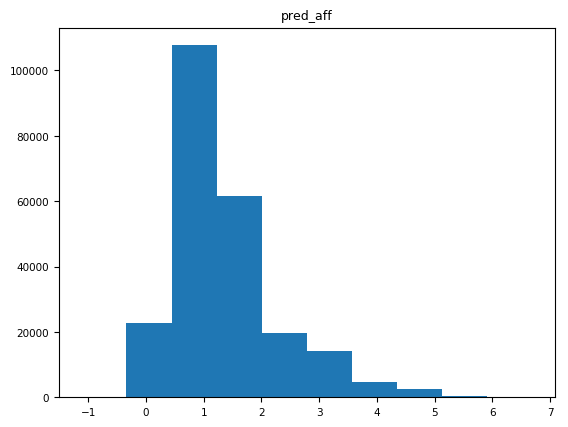

Total number of interactions
535032
Interactions with affinity measurements
232697
Unique MATas
72
Unique MATalphas
2477


In [108]:


#Import raw AlphaSeq data
df0=pd.read_csv('Supplementary_Table4_CoV_SSM_RawData.csv')

#plot distribution of affinity values
plt.hist(df0.pred_aff,bins=10)
plt.title('pred_aff')
plt.show()

print('Total number of interactions')
print(len(df0))
print('Interactions with affinity measurements')
print(len(df0[df0.pred_aff > 0]))
print('Unique MATas')
print(len(df0.mata_description.unique()))
print('Unique MATalphas')
print(len(df0.matalpha_description.unique()))

# Data processing 

In [109]:
df0['interaction'] = df0.mata_description + '$' + df0.matalpha_description 

df=df0.pivot(index='interaction', columns='sample_name', values='pred_aff').reset_index()

df[['mata_description','matalpha_description']] = df.interaction.str.split(expand=True,pat='$') 

df['aff_mean']= df[[1,2,3]].mean(axis=1)
df['aff_std']= df[[1,2,3]].std(axis=1)
df['aff_cv']= np.abs(df.aff_std / df.aff_mean)

df['aff_1_nm']= np.power(10,df[1])
df['aff_2_nm']= np.power(10,df[2])
df['aff_3_nm']= np.power(10,df[3])

df['aff_mean_nm']= df[['aff_1_nm','aff_2_nm','aff_3_nm']].mean(axis=1)
df['aff_std_nm']= df[['aff_1_nm','aff_2_nm','aff_3_nm']].std(axis=1)
df['aff_cv_nm']= np.abs(df.aff_std_nm / df.aff_mean_nm) *100

df=df.sort_values(by='aff_mean')

#Removing observations not seen in all replicates to create quantitative dataset
dfquant=df[~((np.isnan(df[1])) | (np.isnan(df[2])) | (np.isnan(df[3])))]

#Creating dataframe for WT interactiions
dfwtpass=((dfquant[dfquant.matalpha_description.str.contains('SARS-CoV2_RBD')]))

################################################
#Operations to deal with SSM data
################################################

#to remove codon from matalpha description
df.matalpha_description = df.matalpha_description.str.split(expand=True,pat='_')

#to break down 
df[['wt','pos','mut']] = df.matalpha_description.str.extract('^([a-zA-Z]+)(\d+)([a-zA-Z]+)$')
df.pos = pd.to_numeric(df.pos)

#adding offset to SSM position
df.pos = df.pos + 318

In [110]:
print('How many positions?')
print(len(df.pos.dropna().unique()))

print('How many substitutions per site?')
print(len(df.mut.dropna().unique()))

How many positions?
165
How many substitutions per site?
19


In [111]:
print('Total proteins in MatAlpha library mapped')
print(len(df0.matalpha_description.unique()))
print('Total proteins in MatAlpha library from the SSM')
print(len(df.matalpha_description.unique()))

Total proteins in MatAlpha library mapped
2477
Total proteins in MatAlpha library from the SSM
2443


# Merging dataframe with antibody full names

In [112]:
names = pd.read_csv('Supplementary_Table6_AntibodiesNameFormats.csv')
names['Short_Name']=names.Short_Name + '_HL'

names2 = pd.read_csv('Supplementary_Table6_AntibodiesNameFormats.csv')
names2['Short_Name']=names2.Short_Name + '_LH'

names3 = pd.read_csv('Supplementary_Table6_AntibodiesNameFormats.csv')
names3['Short_Name']=names3.Short_Name

names4 = pd.concat([names,names2,names3])
names4.append(pd.DataFrame([['ACE2','ACE2']], columns=['Name','Short_Name']))

df=pd.merge(df,names4,left_on='mata_description',right_on='Short_Name',how='outer').reset_index(drop=True)
df=df.dropna(subset=['mata_description'])

df['binderno']=pd.to_numeric(df.mata_description.str.extract(r'(?:binder_)(\d+)').iloc[:,0])

In [113]:
#Adding orientation LH HL to antibody name
df["ori"] = " "
df["ori"][df['mata_description'].str.contains("LH")] = "_LH"
df["ori"][df['mata_description'].str.contains("HL")] = "_HL"
df['Name&Ori'] = df.Name + df.ori
df.head()

,interaction,1,2,3,mata_description,matalpha_description,aff_mean,aff_std,aff_cv,aff_1_nm,...,aff_cv_nm,wt,pos,mut,Short_Name,Name,Name_extra,binderno,ori,Name&Ori
0,CoV_binder_6_LH$N142H_CAT,NaN,-1.117423,NaN,CoV_binder_6_LH,N142H,-1.117423,NaN,NaN,NaN,...,NaN,N,460.0,H,CoV_binder_6_LH,Tixagevimab,Tixagevimab / AZD8895 / COV2-2196,6.0,_LH,Tixagevimab_LH
1,CoV_binder_6_LH$G95T_ACT,NaN,-0.258673,NaN,CoV_binder_6_LH,G95T,-0.258673,NaN,NaN,NaN,...,NaN,G,413.0,T,CoV_binder_6_LH,Tixagevimab,Tixagevimab / AZD8895 / COV2-2196,6.0,_LH,Tixagevimab_LH
2,CoV_binder_6_LH$Y187E_GAA,NaN,-0.114637,NaN,CoV_binder_6_LH,Y187E,-0.114637,NaN,NaN,NaN,...,NaN,Y,505.0,E,CoV_binder_6_LH,Tixagevimab,Tixagevimab / AZD8895 / COV2-2196,6.0,_LH,Tixagevimab_LH
3,CoV_binder_6_LH$S53K_AAA,NaN,NaN,0.041594,CoV_binder_6_LH,S53K,0.041594,NaN,NaN,NaN,...,NaN,S,371.0,K,CoV_binder_6_LH,Tixagevimab,Tixagevimab / AZD8895 / COV2-2196,6.0,_LH,Tixagevimab_LH
4,CoV_binder_6_LH$F20M_ATG,NaN,0.065080,NaN,CoV_binder_6_LH,F20M,0.065080,NaN,NaN,NaN,...,NaN,F,338.0,M,CoV_binder_6_LH,Tixagevimab,Tixagevimab / AZD8895 / COV2-2196,6.0,_LH,Tixagevimab_LH


# Determining WT binding

In [114]:
#Mergining WT binding dataframe with antibodies names taable
dfwt1=pd.merge(dfwtpass,names4,left_on='mata_description',
               right_on='Short_Name',how='outer').reset_index(drop=True)

#Only selecting those antibodies with measurements in three replicates
dfwt1=dfwt1.dropna()

#Combining names and scfv's orientations
dfwt1["ori"] = " "
dfwt1["ori"][dfwt1['mata_description'].str.contains("LH")] = "_LH"
dfwt1["ori"][dfwt1['mata_description'].str.contains("HL")] = "_HL"
dfwt1['Name&Ori'] = dfwt1.Name + dfwt1.ori
dfwt1=dfwt1.dropna()

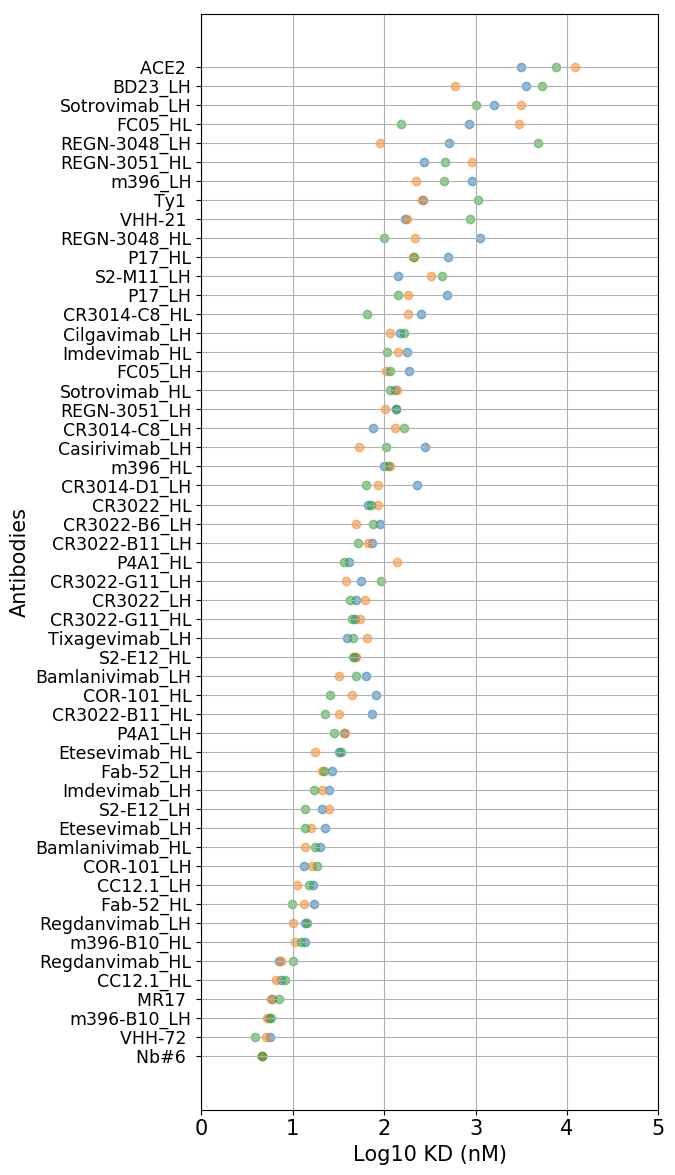

In [115]:
#How do binders bind to WT RBD for all three replicates

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(7,12))

x=np.arange(len(dfwt1))
y=dfwt1[1]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1))
y=dfwt1[2]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1))
y=dfwt1[3]
plt.scatter(y,x,alpha=0.5)

labels=list(dfwt1['Name&Ori'])
plt.yticks(range(len(labels)), labels, size='small')

plt.ylabel('Antibodies')
plt.xlabel('Log10 KD (nM)')

plt.xlim(0,5)

plt.grid()
plt.tight_layout()

# plt.gca().invert_yaxis()
plt.savefig('./figures/Antibody_WT_Epitope.png',dpi=300)
plt.show()

# Epitope antibody pairwise comparison

In [116]:
# Which binders to use for epitope mapping?
# Selecting binders that bound at a KD of300nM (2.5 LOG 10 AFF) 
# or stronger affinity to WT RBD
goodwtbinders_df=dfwtpass[dfwtpass.aff_mean < 2.5].sort_values(by='mata_description')
comparisonbinders=list(goodwtbinders_df.mata_description.unique())
print('How many binders used for pairwise epitope extraction?')
print(len(comparisonbinders))

How many binders used for pairwise epitope extraction?
47


In [117]:
### ~20 minute runtime

#Determine unique list of residues (pos) to do comparison
listpos=df.sort_values(by='pos').dropna(subset=['pos']).pos.unique().astype(int)
resultslist=[]

for queryxx in range(0,len(comparisonbinders)):
    #selecting query binders
    dftemp1 = df[df.mata_description == comparisonbinders[queryxx]]
    print(queryxx)
    for compxx in range(0,len(comparisonbinders)):
        
        #selecting comparison binder
        dftemp2 = df[df.mata_description == comparisonbinders[compxx]]
        
        # normalizing by mean average across SSM
        dftemp1.aff_mean = dftemp1.aff_mean - np.mean(dftemp1.aff_mean)
        dftemp2.aff_mean = dftemp2.aff_mean - np.mean(dftemp2.aff_mean)
    
        #empty lists
        difflist=[]
        plist=[]
        poslist=[]
        querylist=[]
        comparisonlist=[]

        for posxx in range (0,len(listpos)):
            #comparing across position
            
            #all affinity means
            dftemp1_values=dftemp1[dftemp1.pos == listpos[posxx]].aff_mean
            dftemp2_values=dftemp2[dftemp2.pos == listpos[posxx]].aff_mean
            
            #mean difference across substitutions
            diff = np.mean(dftemp1_values) - np.mean(dftemp2_values)
            
            #p-value calculation across substitutions
            #if there are no affinity values in the query or comparison binder, set p to 1
            if ((len(dftemp1_values) > 0)&(len(dftemp2_values) > 0)):
                [stat,p] = stats.mstats.mannwhitneyu(dftemp1_values,dftemp2_values)
            else:
                [stat,p] = [0,1]
            
            #append results to lists
            poslist.append(listpos[posxx])
            difflist.append(diff)
            plist.append(p)
            querylist.append(dftemp1.mata_description.iloc[0])
            comparisonlist.append(dftemp2.mata_description.iloc[0])
        
        #creates output dataframe and appends to list of dataframes
        resultsdf=pd.DataFrame({'pos':poslist,'diff':difflist,'pvalue':plist,'query':querylist,'comp':comparisonlist})

        resultslist.append(resultsdf)
        
finaldf=pd.concat(resultslist).sort_values(by='pvalue')
finaldf.to_csv('Supplementary_Table7_EpitopeComparisonRaw.csv')

In [118]:
#loading results from previous iterations
finaldf = pd.read_csv('Supplementary_Table7_EpitopeComparisonRaw.csv')

#p-value bonferroni correction
correction=np.int(np.float64(len(comparisonbinders)) * np.float64(len(listpos))) 

#all results
# finaldf=pd.concat(resultslist).sort_values(by='pvalue')
# finaldf.to_csv('20210321_epitoperesults.csv')

#filtered mutants based on pvalue thresholding and those with loss of binding
finaldf_fil=finaldf[(finaldf.pvalue < (0.05/correction)) & (finaldf['diff']>0)].sort_values(by='query')
dftemp=df[['mata_description','Name']].drop_duplicates(subset=['mata_description'])
finaldf_fil=finaldf_fil.merge(dftemp,left_on='query',right_on='mata_description',how='left').sort_values('Name')




# Epitope Heatmap

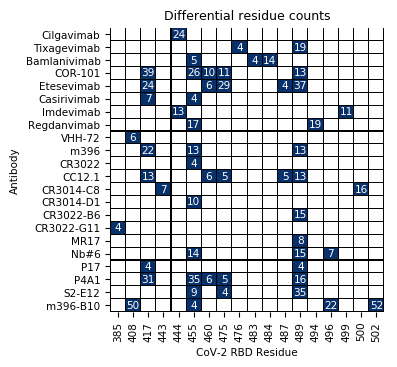

In [124]:
def heatmap1(finaldf_fil,var_name,count_cutoff,sorted_index,height,width,name):

    finaldf_fil['query_pos']=finaldf_fil[var_name] + '&' + finaldf_fil.pos.astype(str)
    dftemp1=pd.DataFrame(finaldf_fil.query_pos.value_counts())
    dftemp1=dftemp1[dftemp1.query_pos > count_cutoff]

    
    indextemp=pd.Series(dftemp1.index)
    dftemp1=dftemp1.reset_index(drop=False)

    dftemp1[[var_name,'pos']]=indextemp.str.split(pat="&",expand=True)
    dftemp1_h=dftemp1.pivot(columns='pos',index=var_name,values='query_pos')

    if len(sorted_index)>0:
        dftemp1_h=dftemp1_h.reindex(index = sorted_index)
    
    dftemp1_h=dftemp1_h.fillna(0)

    dftemp2_h= dftemp1_h[dftemp1_h > count_cutoff]
    
    dftemp2_h= dftemp2_h.dropna(axis=1,how='all')
    dftemp2_h= dftemp2_h.dropna(axis=0,how='all')
    
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 7.5})
    plt.figure(figsize=(width,height))

    sns.heatmap(data=dftemp2_h, cmap='Blues',linewidth=.1,linecolor='black', 
                annot=True, vmax=1, vmin=0, cbar=False)
    
    plt.title('Differential residue counts')
    plt.xticks(rotation=90) 
    plt.xlabel('CoV-2 RBD Residue')
    plt.ylabel('Antibody')
    plt.tight_layout()
    plt.savefig(name,dpi=300)
    plt.show()
    return(dftemp2_h)

sorted_index1 = [
 'Cilgavimab',
 'Tixagevimab',
 'Bamlanivimab',
 'COR-101',
 'Etesevimab',
 'Casirivimab',
 'Imdevimab',
 'Regdanvimab',
 'VHH-72',
 'm396',
 'CR3022',
 'CC12.1',
 'CR3014-C8',
 'CR3014-D1',
 'CR3022-B11',
 'CR3022-B6',
 'CR3022-G11',
 'MR17',
 'Nb#6',
 'P17',
 'P4A1',
 'S2-E12',
 'm396-B10']


#Full heatmap with all dataset
finalcounts=heatmap1(finaldf_fil,'Name',3,sorted_index1,3.7,4,'./full_epitope_counts.png')
finalcounts.to_csv('Supplementary_Table8_EpitopeComparisonFinal.csv')

In [65]:
finaldf_fil

,pos,diff,pvalue,query,comp,mata_description,Name,query_pos
910,484,1.492792,6.150000e-06,CoV_binder_3_HL,CoV_binder_4_HL,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &484
924,484,1.613696,5.050000e-06,CoV_binder_3_HL,CoV_binder_21_LH,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &484
923,373,0.327143,4.500000e-07,CoV_binder_3_HL,SARS_VHH72,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &373
921,484,1.574441,6.150000e-06,CoV_binder_3_HL,CoV_binder_29,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &484
920,494,0.831787,4.630000e-06,CoV_binder_3_HL,SARS_VHH72,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &494
919,483,1.074158,5.310000e-07,CoV_binder_3_HL,SARS_VHH72,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &483
918,335,0.412503,1.540000e-06,CoV_binder_3_HL,SARS_VHH72,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &335
917,484,1.591415,5.050000e-06,CoV_binder_3_HL,CoV_binder_2_LH,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &484
916,484,1.616094,4.140000e-06,CoV_binder_3_HL,CoV_binder_13_LH,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &484
925,455,0.369839,3.320000e-06,CoV_binder_3_HL,CoV_binder_2_LH,CoV_binder_3_HL,Bamlanivimab,Bamlanivimab &455


# Other plots

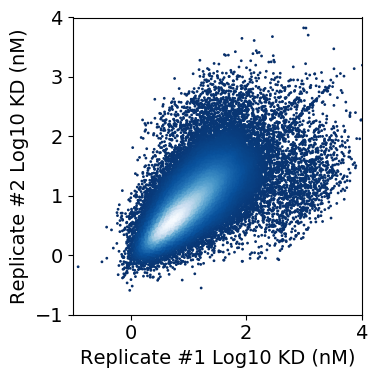

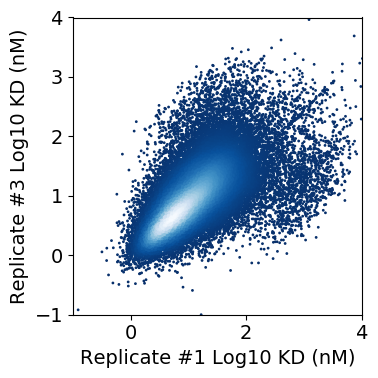

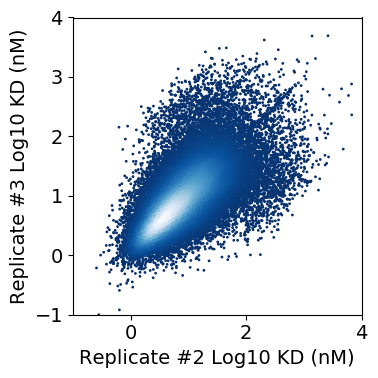

In [43]:
from scipy.stats import gaussian_kde

dftemp = df.dropna() #measurements with values in all three replicates

def plotscatter(rep1,rep2):
    x = dftemp[rep1]
    y = dftemp[rep2]

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    plt.rcParams.update({'font.size': 14})

    plt.figure(figsize=(4,4))
    plt.scatter(x, y, c=z, s=1, cmap='Blues_r')
    plt.xlim(-1,4)
    plt.ylim(-1,4)
    plt.xlabel('Replicate #'+str(rep1)+' Log10 KD (nM)')
    plt.ylabel('Replicate #'+str(rep2)+' Log10 KD (nM)')
    plt.tight_layout()
    plt.savefig('./figures/epitope_replicate'+str(rep1)+str(rep2)+'.png',dpi=300)
    plt.show()
    
    
### Replicate plots
plotscatter(1,2)
plotscatter(1,3)
plotscatter(2,3)

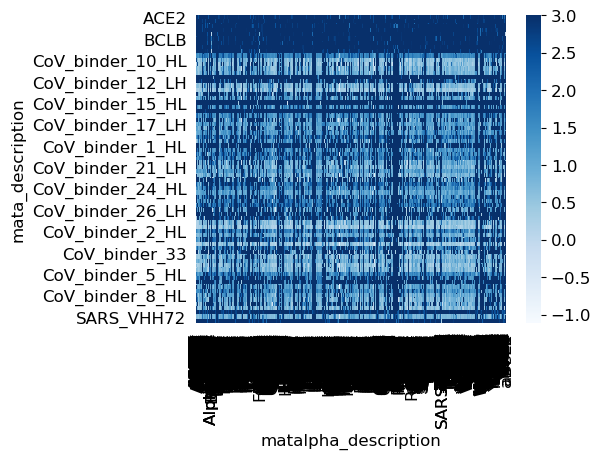

In [44]:
#Ploting all interactions in one large heatmap

dftemp=df.sort_values(by='pos')
dftemp['interaction'] = dftemp.mata_description + '&' + dftemp.matalpha_description
dftemp=dftemp.drop_duplicates(subset=['interaction'])

dfpivot=dftemp.pivot(index='mata_description',columns='matalpha_description',values='aff_mean').astype(float)

weakest=np.max(np.max(dfpivot))
dfpivot=dfpivot.fillna(weakest) #replacing non measured with weakest value measured for viz
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5,4))
g=sns.heatmap(dfpivot,cmap='Blues',vmax=3, xticklabels=True)

g.tick_params(left=False, bottom=False)
plt.savefig('./figures/big_curated_heatmap_epitope.png',dpi=300)
plt.show()

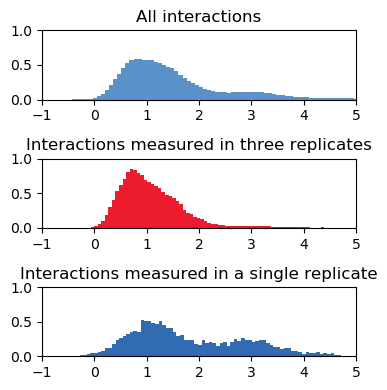

In [45]:
# Plotting affinity of interactions across entire dataset, those observed in 
# three replicates and those observed in one replicate

plt.rcParams.update({'font.size': 10})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4,4))
fig.subplots_adjust(hspace=0.5)

ax1.hist(df.aff_mean, density=True,bins=100,color='#5B91C9')
ax1.title.set_text('All interactions')
ax1.set_xlim([-1, 5])
ax1.set_ylim([0, 1])

ax2.hist(df[~((np.isnan(df[1])) | (np.isnan(df[2])) | (np.isnan(df[3])))].aff_mean, 
         density=True,bins=100,color='#ED1B2E')
ax2.title.set_text('Interactions measured in three replicates')
ax2.set_xlim([-1, 5])
ax2.set_ylim([0, 1])

ax3.hist(df[df[1].isna() & df[2].isna()].aff_mean, density=True,bins=100,color='#316BB1')
ax3.title.set_text('Interactions measured in a single replicate')
ax3.set_xlim([-1, 5])
ax3.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('./figures/Interactions_distributions_epitope.png',dpi=300)
plt.show()
